<a href="https://colab.research.google.com/github/jxie5189/AnimalFaces_GAN/blob/main/AnimalFace_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import time

from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
base_dir = "/content/drive/MyDrive/animals_gan"

folder_names = os.listdir(base_dir)

In [ ]:
folder_names

['.DS_Store', 'val', 'train']

In [ ]:
train_folder = os.path.join(base_dir, 'train')
train_folder = os.listdir(train_folder)

In [ ]:
train_folder

['dog', 'wild', 'cat']

In [ ]:
train_data = []
base_dir = "/content/drive/MyDrive/animals_gan"

for folder in train_folder:
  for fileName in os.listdir(base_dir+'/train/'+folder):
    if fileName.__contains__("flickr"):
      train_data.append({'path':os.path.join('/content/drive/MyDrive/animals_gan/train/',folder, fileName), 'label':folder})

#/content/drive/MyDrive/animals_gan/train/dog/flickr_dog_000002.jpg


In [ ]:
train_data[0]

{'path': '/content/drive/MyDrive/animals_gan/train/dog/flickr_dog_000771.jpg',
 'label': 'dog'}

In [ ]:
len(train_data)

5426

In [ ]:
train_df = pd.DataFrame(train_data)

In [ ]:
train_df.head()

,path,label
0,/content/drive/MyDrive/animals_gan/train/dog/f...,dog
1,/content/drive/MyDrive/animals_gan/train/dog/f...,dog
2,/content/drive/MyDrive/animals_gan/train/dog/f...,dog
3,/content/drive/MyDrive/animals_gan/train/dog/f...,dog
4,/content/drive/MyDrive/animals_gan/train/dog/f...,dog


In [ ]:
train_df['path'][0]

'/content/drive/MyDrive/animals_gan/train/dog/flickr_dog_000771.jpg'

In [ ]:
dog_df = train_df[train_df['label']=='dog']
cat_df = train_df[train_df['label']=='cat']
wild_df = train_df[train_df['label']=='wild']

In [ ]:
print(len(dog_df))
print(len(cat_df))
print(len(wild_df))

1103
731
3592


#Data Processing

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image as PILImage
from PIL import ImageOps

def processImage(path):
  i = PILImage.open(path)
  i = ImageOps.pad(i, (28, 28), method=0, color=None)
  img_array = (img_to_array(i)- 255) /255.0
  return img_array

In [ ]:
dog_df['img_array'] = dog_df['path'].apply(processImage)

<ipython-input-16-545286fdd9b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dog_df['img_array'] = dog_df['path'].apply(processImage)


In [ ]:
dog_df.head()

,path,label,img_array
0,/content/drive/MyDrive/animals_gan/train/dog/f...,dog,"[[[-0.44313726, -0.49803922, -0.5019608], [-0...."
1,/content/drive/MyDrive/animals_gan/train/dog/f...,dog,"[[[-0.41960785, -0.5568628, -0.6745098], [-0.5..."
2,/content/drive/MyDrive/animals_gan/train/dog/f...,dog,"[[[-0.3529412, -0.43137255, -0.4745098], [-0.4..."
3,/content/drive/MyDrive/animals_gan/train/dog/f...,dog,"[[[-0.047058824, -0.043137256, -0.0627451], [-..."
4,/content/drive/MyDrive/animals_gan/train/dog/f...,dog,"[[[-0.1764706, -0.17254902, -0.15294118], [-0...."


In [ ]:
from IPython.display import display as IpyDisplay, Image as IpyImage

def display(path):
  image_path = path
  return IpyDisplay(IpyImage(filename=image_path))

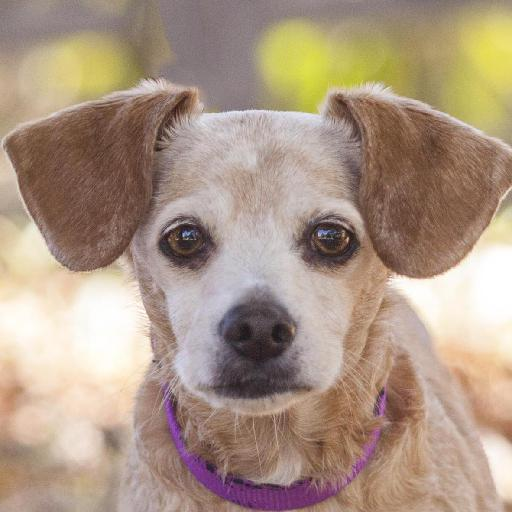

In [ ]:
display(test)

#Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocessImage(img):
  #return (img-127.5)/127.5
  return (img+1.0)/2.0

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocessImage,
    rescale = 1./255,
)

In [ ]:
BATCH_SIZE = 256

train_generator_dog = train_datagen.flow_from_dataframe(
    dataframe=dog_df,
    target_size=(28,28),
    #color_mode = 'grayscale',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    x_col='path',
    y_col='label',
    shuffle=True,
    seed=42,
)

Found 1103 validated image filenames belonging to 1 classes.


In [ ]:
train_generator_wild = train_datagen.flow_from_dataframe(
    dataframe=wild_df,
    target_size=(28,28),
    #color_mode = 'grayscale',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    x_col='path',
    y_col='label',
    shuffle=True,
    seed=42,
)

Found 3592 validated image filenames belonging to 1 classes.


In [ ]:
train_generator_cat = train_datagen.flow_from_dataframe(
    dataframe=cat_df,
    target_size=(28,28),
    #color_mode = 'grayscale',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    x_col='path',
    y_col='label',
    shuffle=True,
    seed=42,
)

Found 731 validated image filenames belonging to 1 classes.


#Make Generator

In [ ]:
from tensorflow.keras import initializers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(100,)))
    model.add(layers.Dense(7*7*256, use_bias=False, kernel_initializer='he_normal'))

    model.add(layers.BatchNormalization(momentum=0.8, epsilon=0.002))
    model.add(layers.ReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8, epsilon=0.002))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8, epsilon=0.002))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

In [ ]:
generator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_39 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_10 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_38 (Conv2  (None, 14, 14, 128)       524288    
 DTranspose)                                                     
                                                                 
 batch_normalization_40 (Ba  (None, 14, 14, 128)     

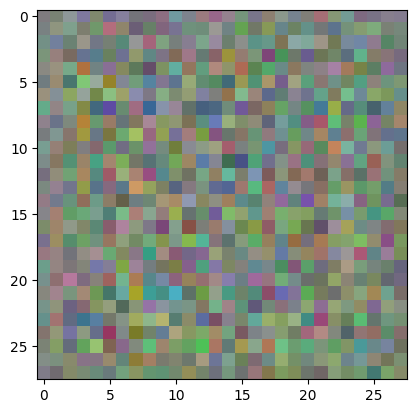

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

#generated_image = (generator_image + 1.0) / 2.0

plt.imshow((generated_image[0, :, :, :]+1.0) / 2.0)


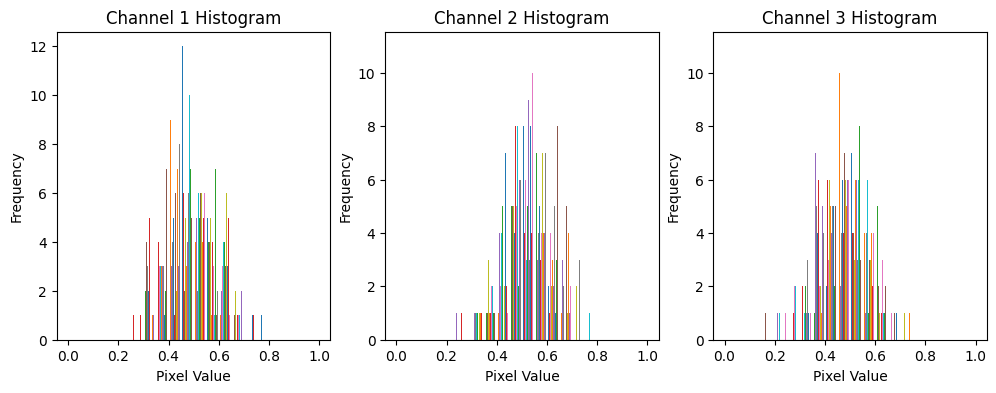

In [ ]:
plt.figure(figsize=(12, 4))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist((generated_image[0, :, :, i] + 1.0) / 2.0, bins=20, range=[0, 1])
    plt.title(f'Channel {i+1} Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.show()

In [ ]:
print(np.min(generated_image))
print(np.max(generated_image))

-0.6841404
0.6172474


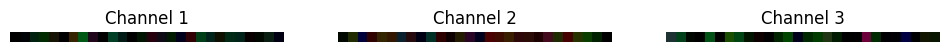

In [ ]:
plt.figure(figsize=(12, 4))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(generated_image[:, :, i], cmap='gray')  # Use 'gray' cmap for individual channels
    plt.title(f'Channel {i+1}')
    plt.axis('off')

plt.show()

#Make a discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        4864      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)            

#Loss function

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed over time (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [ ]:
# `tf.function` causes the function to be "compiled".
#@tf.function
def train_step(images):

    batch_size = images[0].shape[0]

    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(noise, training=True)

      real_output = discriminator(images[0], training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs, steps_per_epoch):
  time_stamps = []
  for epoch in range(epochs):
    #print('epoch '+str(epoch))
    start = time.time()

    for step in range(steps_per_epoch):
      image_batch = next(dataset)
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    time_stamps.append(time.time()-start)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  print(time_stamps)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] +1.0) / 2.0)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()



In [ ]:
len(dog_df)

1103

In [ ]:
len(wild_df)

3592

In [ ]:
BATCH_SIZE

256

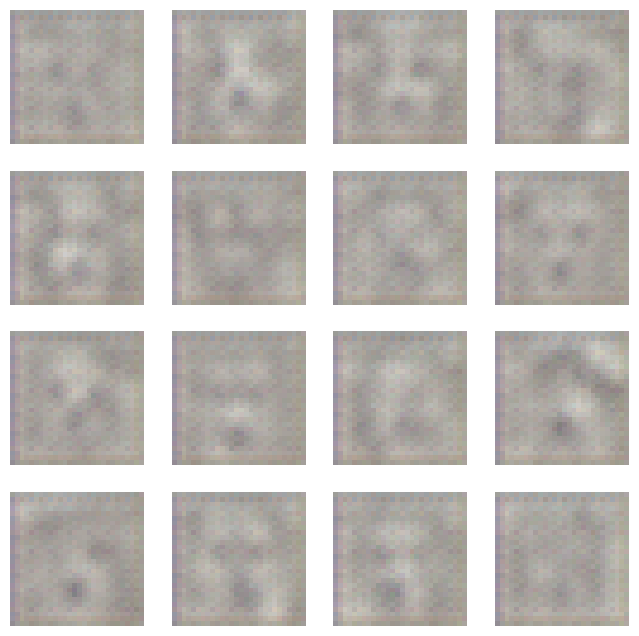

[3.113535165786743, 2.9539084434509277, 2.9439494609832764, 2.9303767681121826, 2.707927942276001, 3.0304086208343506, 2.9904873371124268, 2.8758020401000977, 2.740931272506714, 2.8027780055999756, 3.172851085662842, 2.9949209690093994, 2.8277556896209717, 2.6537749767303467, 2.8878839015960693, 3.347353935241699, 2.8524765968322754, 2.8780853748321533, 2.796905517578125, 2.7007997035980225, 3.519005060195923, 2.8776750564575195, 2.7441084384918213, 2.8049163818359375, 2.7081308364868164, 3.429309129714966, 2.756298542022705, 2.7524704933166504, 2.810040235519409, 3.2127017974853516, 3.1664652824401855, 2.7801191806793213, 2.753049612045288, 2.821532726287842, 3.057032585144043, 3.2119181156158447, 2.710167169570923, 2.7046546936035156, 2.6599457263946533, 3.122422933578491, 3.22965407371521, 2.7643725872039795, 2.751854658126831, 3.0933125019073486, 2.9969899654388428, 3.104832887649536, 2.8087286949157715, 2.7242746353149414, 3.0619895458221436, 2.846144914627075, 3.0924172401428223,

In [ ]:
train(train_generator_dog, EPOCHS, (len(dog_df)//BATCH_SIZE))

#Make Application

In [ ]:
class AnimalMaker:

  def makeAnimalPic(animal):
    if animal == 'dog':
      return dog_df
    elif animal == 'cat':
      return cat_df
    elif animal == 'wild':
      return wild_df
    else:
      return "animal not found"

In [ ]:
animalMaker = AnimalMaker()